<a href="https://colab.research.google.com/github/Tranminhtuan48/Object-Detection-Models/blob/main/RetinaNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%javascript
function ClickConnect(){
console.log("Working");
document.querySelector("colab-toolbar-button#connect").click()
}setInterval(ClickConnect,60000)

# **Install Pytorch Retinanet và Dependencies** :

In [ ]:
!pip install -Uqq pytorch-lightning==1.0.0 omegaconf
!pip install -Uqq git+https://github.com/albumentations-team/albumentations
!pip uninstall torchtext
!git clone https://github.com/benihime91/pytorch_retinanet.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
fatal: destination path 'pytorch_retinanet' already exists and is not an empty directory.


In [ ]:
#Update sys path to include the pytorch RetinaNet modules
import warnings
import os
import sys

warnings.filterwarnings('ignore')
sys.path.append("/content/pytorch_retinanet/")
%load_ext autoreload
%autoreload 2
%matplotlib inline

# **Retinanet Object Detection Training Data [Pytorch]**

Datasets: **[Pothole Dataset](https://public.roboflow.com/object-detection/pothole)** từ RoboFlow.

Download dứoi dạng Pascal VOC rồi dùng n-built methods sẵn có trong PyTorch Retinanet để chuyển đổi thành csv.

In [ ]:
%cd /content
!curl -L "https://public.roboflow.com/ds/raYZw3Bbge?key=84KRPnaeTz" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

/content
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   900  100   900    0     0   1736      0 --:--:-- --:--:-- --:--:--  1737
100 46.5M  100 46.5M    0     0  7795k      0  0:00:06  0:00:06 --:--:-- 11.5M
Archive:  roboflow.zip
 extracting: README.dataset.txt      
 extracting: README.roboflow.txt     
   creating: test/
 extracting: test/img-105_jpg.rf.3fe9dff3d1631e79ecb480ff403bcb86.jpg  
 extracting: test/img-105_jpg.rf.3fe9dff3d1631e79ecb480ff403bcb86.xml  
 extracting: test/img-107_jpg.rf.2e40485785f6e5e2efec404301b235c2.jpg  
 extracting: test/img-107_jpg.rf.2e40485785f6e5e2efec404301b235c2.xml  
 extracting: test/img-146_jpg.rf.61be25b3053a51f622a244980545df2b.jpg  
 extracting: test/img-146_jpg.rf.61be25b3053a51f622a244980545df2b.xml  
 extracting: test/img-161_jpg.rf.211541e7178a4a93ec0680f26b905427.jpg  
 extracting: test/img-161_jpg.rf.211541e7178a4a93ec06

In [ ]:
# Paths

#Images path
TRAIN_IMAGE_PATH = "/content/train/"
VALID_IMAGE_PATH = "/content/valid/"
TEST_IMAGE_PATH  = "/content/test/"
#annotations path
TRAIN_ANNOT_PATH = "/content/train/"
VALID_ANNOT_PATH = "/content/valid/"
TEST_ANNOT_PATH  = "/content/test/"

In [ ]:
import pandas as pd
from PIL import Image
import cv2
import numpy as np

from utils.pascal import convert_annotations_to_df

pd.set_option("display.max_colwidth", None)
np.random.seed(123)

## **Tạo csv file từ file XML Annotations của roboflow:**

In [ ]:
#xml files -> pandas DataFrames
train_df = convert_annotations_to_df(TRAIN_ANNOT_PATH, TRAIN_IMAGE_PATH, image_set="train")
valid_df = convert_annotations_to_df(VALID_ANNOT_PATH, VALID_IMAGE_PATH, image_set="test")
test_df  = convert_annotations_to_df(TEST_ANNOT_PATH, TEST_IMAGE_PATH, image_set="test")


def remove_invalid_annots(df):
    df = df[df.xmax > df.xmin]
    df = df[df.ymax > df.ymin]
    df.reset_index(inplace=True, drop=True)
    return df
#Loại các annotation lỗi:
train_df = remove_invalid_annots(train_df)
valid_df = remove_invalid_annots(valid_df)
test_df  = remove_invalid_annots(test_df)

### **Check file**

In [ ]:
train_df.head()

,filename,width,height,class,xmin,ymin,xmax,ymax,labels
0,/content/train/img-595_jpg.rf.f7d0b11ae9ac53ec52b154e001c576e1.jpg,300,300,pothole,162,155,241,214,1
1,/content/train/img-595_jpg.rf.f7d0b11ae9ac53ec52b154e001c576e1.jpg,300,300,pothole,33,215,164,298,1
2,/content/train/img-595_jpg.rf.f7d0b11ae9ac53ec52b154e001c576e1.jpg,300,300,pothole,192,264,291,300,1
3,/content/train/img-595_jpg.rf.f7d0b11ae9ac53ec52b154e001c576e1.jpg,300,300,pothole,253,204,300,245,1
4,/content/train/img-595_jpg.rf.f7d0b11ae9ac53ec52b154e001c576e1.jpg,300,300,pothole,45,113,162,162,1


In [ ]:
valid_df.head()

,filename,width,height,class,xmin,ymin,xmax,ymax,labels
0,/content/valid/img-312_jpg.rf.0a6234042edc7a46cfb556423895c286.jpg,533,300,pothole,8,118,497,246,1
1,/content/valid/img-373_jpg.rf.e9b2fc295556d6755edf71ca30fa2f42.jpg,450,300,pothole,104,133,348,263,1
2,/content/valid/img-204_jpg.rf.9f0bd6fce321437c0ae1b972d37e491a.jpg,720,720,pothole,190,175,358,315,1
3,/content/valid/img-204_jpg.rf.9f0bd6fce321437c0ae1b972d37e491a.jpg,720,720,pothole,281,381,447,519,1
4,/content/valid/img-443_jpg.rf.7922db00bc35543191b2b6f3a5e307b1.jpg,533,300,pothole,36,187,143,217,1


In [ ]:
test_df.head()

,filename,width,height,class,xmin,ymin,xmax,ymax,labels
0,/content/test/img-276_jpg.rf.acc167b63d79ab3b99fd64b4109f86d4.jpg,720,720,pothole,266,307,485,483,1
1,/content/test/img-146_jpg.rf.61be25b3053a51f622a244980545df2b.jpg,720,720,pothole,153,253,439,421,1
2,/content/test/img-590_jpg.rf.7ee475f30ca7858338589be9820a3978.jpg,534,300,pothole,92,131,475,300,1
3,/content/test/img-344_jpg.rf.dd4eebb8836b8efe2a2cce77d61349b7.jpg,449,300,pothole,244,65,333,83,1
4,/content/test/img-344_jpg.rf.dd4eebb8836b8efe2a2cce77d61349b7.jpg,449,300,pothole,300,1,374,12,1


In [ ]:
TRAIN_CSV = "/content/train_data.csv"
VALID_CSV = "/content/valid_data.csv"
TEST_CSV  = "/content/test_data.csv"

train_df.to_csv(TRAIN_CSV, index=False)
valid_df.to_csv(VALID_CSV, index=False)
test_df.to_csv(TEST_CSV, index=False)

In [ ]:
train_df = pd.read_csv(TRAIN_CSV)
valid_df = pd.read_csv(VALID_CSV)
test_df  = pd.read_csv(TEST_CSV)

# **View Images from the Dataset** :

Sử dụng func `visualize_boxes_and_labels_on_image_array` trong repo của RetinaNet để visualize và vẽ bounding boxes cho ảnh. Ta cần tạo Label Map chứa các class tương ứng với labels.

##**Label Map**

In [ ]:
from utils.pascal import generate_pascal_category_names

LABEL_MAP = generate_pascal_category_names(train_df)
LABEL_MAP

['__background__', 'pothole']

##**Bounding boxes**:

In [ ]:
from utils import visualize_boxes_and_labels_on_image_array as viz_bbs
import matplotlib.pyplot as plt


def grab_bbs_(dataframe, index:int):
    assert index <= len(dataframe), f"Invalid index for dataframe with len: {len(dataframe)}"
    fname = dataframe.filename[index] # path [image]
    locs  = dataframe.loc[dataframe.filename == fname]
    bbs   = locs[["xmin", "ymin", "xmax", "ymax"]].values # -> list chứa bounding annotations tương ứng vói fname
    cls   = locs["labels"].values # -> list chứa labels cho box annotations.
    return fname, bbs, cls

def load_image_from_data(dataframe, index):
    image, boxes, clas = grab_bbs_(dataframe, index)
    #normalization
    image = Image.open(image)
    image = np.array(image) / 255.
    image = viz_bbs(image, boxes, scores=None, classes=clas, label_map=LABEL_MAP)
    return image

### **Image [Train]:**

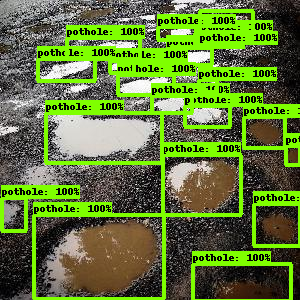

In [ ]:
image = load_image_from_data(train_df, index=10)
image

### **Image [Validation]:**

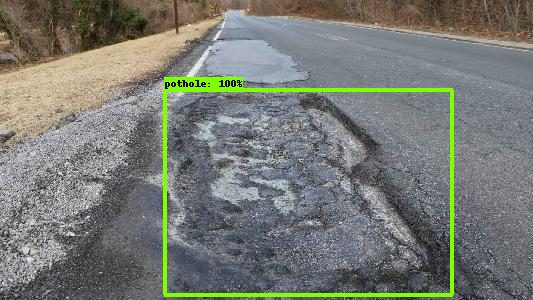

In [ ]:
image = load_image_from_data(valid_df, index=10)
image

###**Image [Test]:**

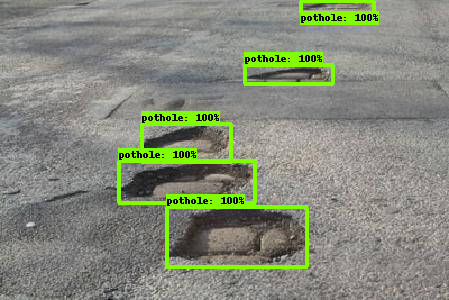

In [ ]:
image = load_image_from_data(test_df, index=5)
image

#**Custom Training Config** :

File config: `/content/pytorch_retinanet/hparams.yaml`.


In [ ]:
from omegaconf import OmegaConf

NUM_TRAIN_EPOCHS = 50

hparams = OmegaConf.load("/content/pytorch_retinanet/hparams.yaml")

# MODIFY CONFIG FILE -> FIX PATHS & DATSET-ARGUEMENTS :
hparams.dataset.kind        = "csv"
hparams.dataset.trn_paths   = TRAIN_CSV
hparams.dataset.valid_paths = VALID_CSV
hparams.dataset.test_paths  = TEST_CSV

hparams.dataloader.train_bs = 1
hparams.dataloader.valid_bs = 16
hparams.dataloader.test_bs  = 16

hparams.model.num_classes   = len(LABEL_MAP) - 1
hparams.model.backbone_kind = "resnet34"
hparams.model.min_size      = 800
hparams.model.max_size      = 1333
#loads imagenet-backbone weights
hparams.model.pretrained    = True

#transforms train data
hparams.transforms  =  [
    {"class_name": "albumentations.HorizontalFlip", "params": {"p": 0.5} },
    {"class_name": "albumentations.ShiftScaleRotate", "params": {"p": 0.5} },
    {"class_name": "albumentations.RandomBrightnessContrast", "params": {"p": 0.5} },
]

#optimizer
hparams.optimizer = {
    "class_name": "torch.optim.SGD",
    "params"    : {"lr": 0.001, "weight_decay": 0.0005, "momentum":0.9},
    }

#scheduler
hparams.scheduler = {
    "class_name" : "torch.optim.lr_scheduler.CosineAnnealingLR",
    "params"     : {"T_max": NUM_TRAIN_EPOCHS},
    "monitor"    : None,
    "interval"   : "epoch",
    "frequency"  : 1
    }

print(OmegaConf.to_yaml(hparams))

model:
  backbone_kind: resnet34
  num_classes: 1
  freeze_bn: true
  min_size: 800
  max_size: 1333
  pretrained: true
dataset:
  kind: csv
  root_dir: false
  trn_paths: /content/train_data.csv
  valid_paths: /content/valid_data.csv
  test_paths: /content/test_data.csv
dataloader:
  train_bs: 1
  valid_bs: 16
  test_bs: 16
  args:
    num_workers: 0
    pin_memory: true
transforms:
- class_name: albumentations.HorizontalFlip
  params:
    p: 0.5
- class_name: albumentations.ShiftScaleRotate
  params:
    p: 0.5
- class_name: albumentations.RandomBrightnessContrast
  params:
    p: 0.5
optimizer:
  class_name: torch.optim.SGD
  params:
    lr: 0.001
    weight_decay: 0.0005
    momentum: 0.9
scheduler:
  class_name: torch.optim.lr_scheduler.CosineAnnealingLR
  params:
    T_max: 50
  monitor: null
  interval: epoch
  frequency: 1



#**Lightning-Module & Lightning-Trainer**

In [ ]:
!pip install --upgrade torch

In [ ]:
import torch

print(torch.__version__)


2.3.1+cu121


In [ ]:
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import LearningRateMonitor, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
import torchvision
from model import RetinaNetModel

# check seed
pl.seed_everything(123)

123

## **Load Lighning-Trainer :**

In [ ]:
#LIGHTNING-TRAINER with CALLBACKS :
lr_logger  = LearningRateMonitor(logging_interval="step")

trainer    = Trainer(precision=16, gpus=1, callbacks=[lr_logger], max_epochs=NUM_TRAIN_EPOCHS)

GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
TPU available: False, using: 0 TPU cores
INFO:lightning:TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Using native 16bit precision.
INFO:lightning:Using native 16bit precision.


In [ ]:
litModel = RetinaNetModel(conf=hparams)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 291MB/s]
BACKBONE     : resnet34
INFO:retinanet.models:BACKBONE     : resnet34
INPUT_PARAMS : MAX_SIZE=1333, MIN_SIZE=800
INFO:retinanet.models:INPUT_PARAMS : MAX_SIZE=1333, MIN_SIZE=800
NUM_CLASSES  : 1
INFO:retinanet.models:NUM_CLASSES  : 1


In [ ]:
trainer.fit(litModel)


  | Name | Type      | Params
-----------------------------------
0 | net  | Retinanet | 29 M  
INFO:retinanet.models:
  | Name | Type      | Params
-----------------------------------
0 | net  | Retinanet | 29 M  


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

1

#**Evaluate train-model bằng COCO-API Metrics** :

In [ ]:
trainer.test(litModel)

creating index...
index created!


Testing: 0it [00:00, ?it/s]

Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.01s).
Accumulating evaluation results...
DONE (t=0.01s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.008
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.013
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.013
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.010
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.200
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=

[{'AP': 0.0077684691546077685}]

# **Export model weights** :

In [ ]:
import torch
PATH = f"/content/trained_weights.pth"
torch.save(litModel.net.state_dict(), PATH)

#**Load Model trained Lightning-Module weights :**

In [ ]:
import logging
logger = logging.getLogger("lightning")

In [ ]:
from retinanet import Retinanet

#load saved model
state_dict = torch.load(PATH)
#model arguments = train model arguments
model_args = hparams.model
#load model without lightning-module using args & state dict
MODEL      = Retinanet(**model_args, logger=logger)
MODEL.load_state_dict(state_dict)
MODEL.eval()
MODEL.to("cuda:0");

BACKBONE     : resnet34
INFO:retinanet.models:BACKBONE     : resnet34
INPUT_PARAMS : MAX_SIZE=1333, MIN_SIZE=800
INFO:retinanet.models:INPUT_PARAMS : MAX_SIZE=1333, MIN_SIZE=800
NUM_CLASSES  : 1
INFO:retinanet.models:NUM_CLASSES  : 1


# **Chạy Predict trên Test img bằng Custom Model**

In [ ]:
from PIL import Image
import numpy as np
import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt

@torch.no_grad()
def get_preds(path, threshold=0.6,):
    image = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)

    INFER_TRANSFORMS = A.Compose([
        A.ToFloat(max_value=255.0, always_apply=True),
        ToTensorV2(always_apply=True)
        ])

    TENSOR_IMAGE = INFER_TRANSFORMS(image=image)["image"].to("cuda:0")
    PREDICTIONS  = MODEL.predict([TENSOR_IMAGE])
    return PREDICTIONS[0]

def detect(image_path, threshold=0.6):
    preds = get_preds(image_path, threshold,)
    # Filter pred
    boxes, labels, scores = preds["boxes"], preds["labels"], preds["scores"]
    mask   = scores > threshold
    boxes  = boxes[mask]
    labels = labels[mask]
    scores = scores[mask]
    return boxes.cpu().numpy(), labels.cpu().numpy(), scores.cpu().numpy()

def draw_on_image(image_path, boxes, scores, classes, label_map=LABEL_MAP):
    image = Image.open(image_path)
    image = np.array(image) / 255.
    image = viz_bbs(image, boxes, scores=scores, classes=classes, label_map=LABEL_MAP)
    return image

### Check

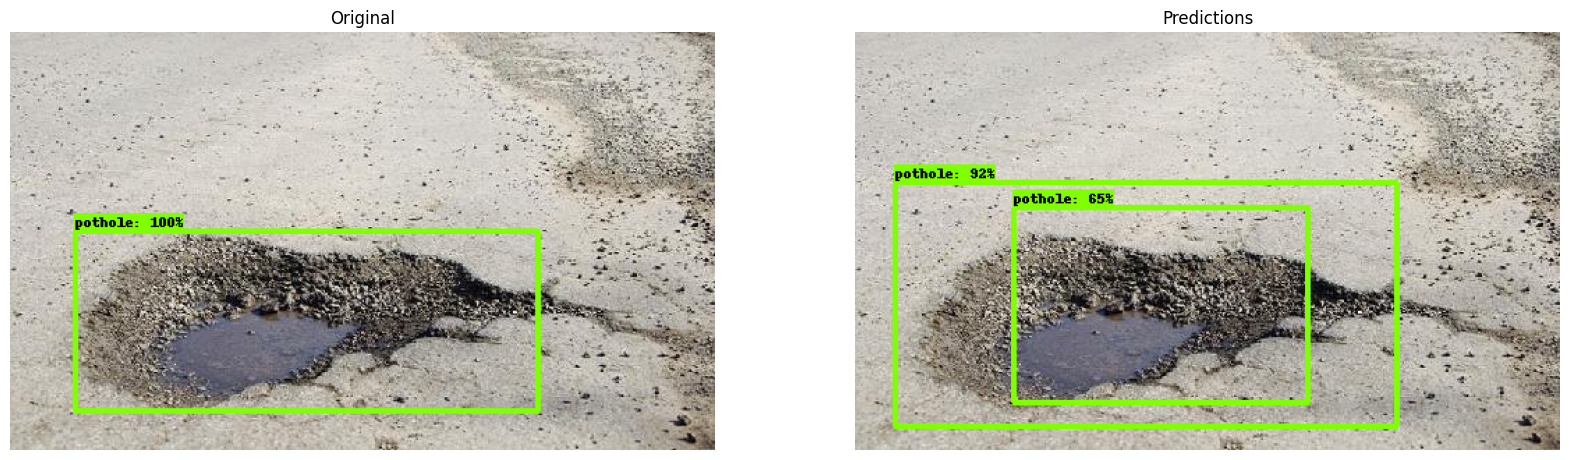

In [ ]:
idx = np.random.randint(len(test_df))
image_path = test_df.filename[idx]

boxes, labels, scores = detect(image_path, threshold=0.48)

pred_image = draw_on_image(image_path, boxes, scores, labels)

real_image = load_image_from_data(test_df, index=idx)


fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(20,7))

ax1.imshow(real_image)
ax1.set_title("Original")
ax1.axis("off")

ax2.imshow(pred_image)
ax2.set_title("Predictions")
ax2.axis("off");

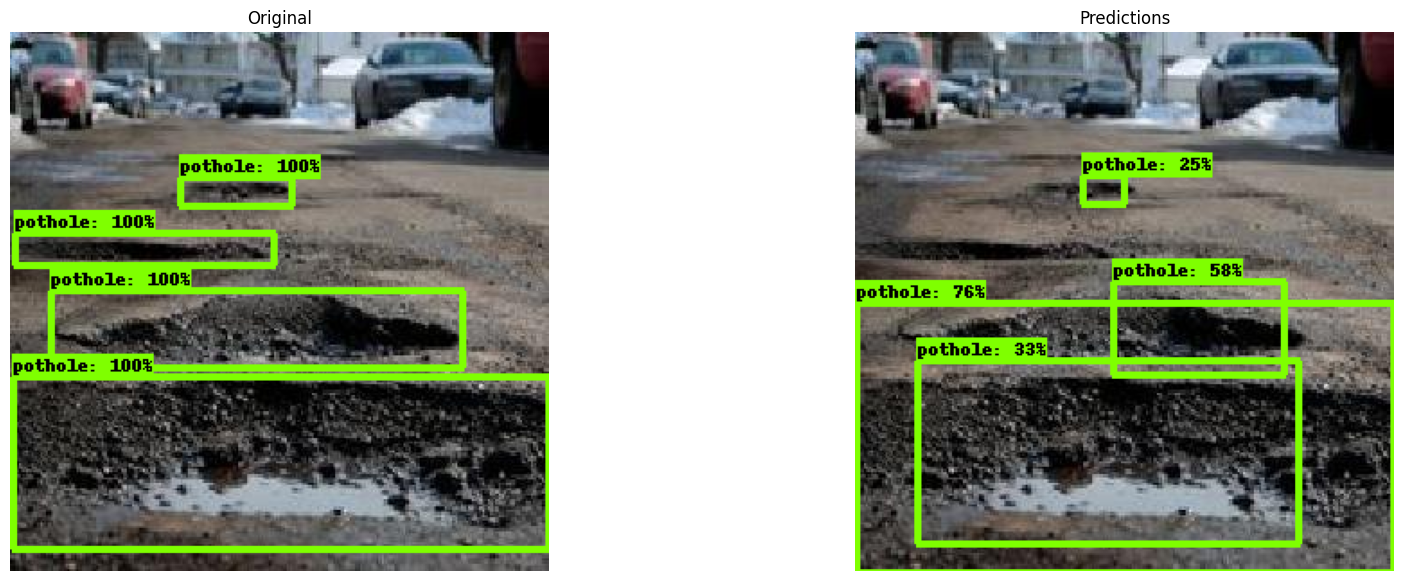

In [ ]:
idx = np.random.randint(len(test_df))
image_path = test_df.filename[idx]

boxes, labels, scores = detect(image_path, threshold=0.2)

pred_image = draw_on_image(image_path, boxes, scores, labels)

real_image = load_image_from_data(test_df, index=idx)


fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(20,7))

ax1.imshow(real_image)
ax1.set_title("Original")
ax1.axis("off")

ax2.imshow(pred_image)
ax2.set_title("Predictions")
ax2.axis("off");